# Setting Up Environment

All imports neccesary!

In [ ]:
pip install tensorflow

In [3]:
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data Uploading

Download the "Reviews.csv" file from https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews. The upload it to your workspace. The dataset contains more than 500,000 amazon reviews.

In [5]:
df = pd.read_csv("Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Here is a preview of what the dataset looks like.

# Data Pre-Processing

We want our dataset to be large but manageable, so we choose a size of 100,000. Unfortunately, this dataset has far more positive reviews then negative reviews, approximately 85% of the reviews are positive. This isn't the best for the model training.

In [6]:
# Keep only necessary columns
df = df[['Text', 'Score']]
df = df.dropna()

# Assign sentiment labels (1-2 = negative -> 0, 3-5 = positive -> 1)
def score_to_sentiment(score):
    if score in [1, 2]:
        return 0
    elif score in [3, 4, 5]:
        return 1
    else:
        return None

df['label'] = df['Score'].apply(score_to_sentiment)
df = df.dropna(subset=['label'])  # Just in case

# Prepare texts and labels
texts = df['Text'].astype(str).tolist()
labels = df['label'].astype(int).tolist()
texts = texts[:100000]
labels = labels[:100000]

# Tokenization
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Padding
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Convert to PyTorch tensors
X = torch.tensor(padded_sequences, dtype=torch.long)
y = torch.tensor(labels, dtype=torch.float32)

# Split off 10% for test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Split remaining 90% into 70% train and 20% val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=2/9, random_state=42)

# Create Datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("Data preprocessing complete.")


Data preprocessing complete.


# Model Creation

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])  # take last hidden state
        x = self.fc1(hidden)
        x = self.relu(x)
        out = self.fc2(x)
        return out  # raw logits output

# Model hyperparameters
VOCAB_SIZE = 5000
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

# Use BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model creation complete.")



Model creation complete.


# Model Training

In [15]:
train_losses = []
val_accuracies = []

val_precisions = []
val_recalls = []
val_f1s = []

# Early stopping parameters
patience = 2    # Number of epochs to wait after no improvement
best_val_acc = 0
epochs_no_improve = 0
early_stop = False

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, leave=True)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs).view(-1)
        labels = labels.view(-1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(loss=loss.item())

    # ✅ Use val_loader for validation (not test_loader)
    model.eval()
    total_correct = 0
    total = 0

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).view(-1)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            labels = labels.view(-1)
            total_correct += (preds == labels).sum().item()
            total += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    val_acc = total_correct / total
    avg_train_loss = total_loss / len(train_loader)

    # Compute precision, recall, f1
    precision = precision_score(true_labels, predicted_labels, zero_division=0)
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)

    # Save metrics
    train_losses.append(avg_train_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1s.append(f1)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


Epoch [1/10]: 100%|██████████| 2188/2188 [01:12<00:00, 30.36it/s, loss=0.467]


Epoch 1/10, Train Loss: 0.4273, Val Acc: 0.8540, Precision: 0.8540, Recall: 1.0000, F1: 0.9213


Epoch [2/10]: 100%|██████████| 2188/2188 [01:09<00:00, 31.50it/s, loss=0.131]


Epoch 2/10, Train Loss: 0.3621, Val Acc: 0.8844, Precision: 0.8958, Recall: 0.9784, F1: 0.9353


Epoch [3/10]: 100%|██████████| 2188/2188 [01:09<00:00, 31.68it/s, loss=0.106]


Epoch 3/10, Train Loss: 0.2335, Val Acc: 0.9111, Precision: 0.9260, Recall: 0.9736, F1: 0.9492


Epoch [4/10]: 100%|██████████| 2188/2188 [01:09<00:00, 31.54it/s, loss=0.0283]


Epoch 4/10, Train Loss: 0.1819, Val Acc: 0.9121, Precision: 0.9225, Recall: 0.9793, F1: 0.9501


Epoch [5/10]: 100%|██████████| 2188/2188 [01:09<00:00, 31.53it/s, loss=0.257]


Epoch 5/10, Train Loss: 0.1446, Val Acc: 0.9190, Precision: 0.9367, Recall: 0.9707, F1: 0.9534


Epoch [6/10]: 100%|██████████| 2188/2188 [01:09<00:00, 31.27it/s, loss=0.367]


Epoch 6/10, Train Loss: 0.1109, Val Acc: 0.9160, Precision: 0.9438, Recall: 0.9586, F1: 0.9512


Epoch [7/10]: 100%|██████████| 2188/2188 [01:09<00:00, 31.61it/s, loss=0.0164]


Epoch 7/10, Train Loss: 0.0857, Val Acc: 0.9144, Precision: 0.9449, Recall: 0.9556, F1: 0.9502
Early stopping triggered at epoch 7


# Checking Metrics

In [16]:
# Load best model (from early stopping)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

total_correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).view(-1)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        labels = labels.view(-1)

        total_correct += (preds == labels).sum().item()
        total += labels.size(0)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

test_acc = total_correct / total
precision = precision_score(true_labels, predicted_labels, zero_division=0)
recall = recall_score(true_labels, predicted_labels, zero_division=0)
f1 = f1_score(true_labels, predicted_labels, zero_division=0)

print("\nFinal Test Set Evaluation:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall:    {recall:.4f}")
print(f"Test F1 Score:  {f1:.4f}")


Final Test Set Evaluation:
Test Accuracy: 0.9160
Test Precision: 0.9339
Test Recall:    0.9700
Test F1 Score:  0.9516


# Plotting Model Performance

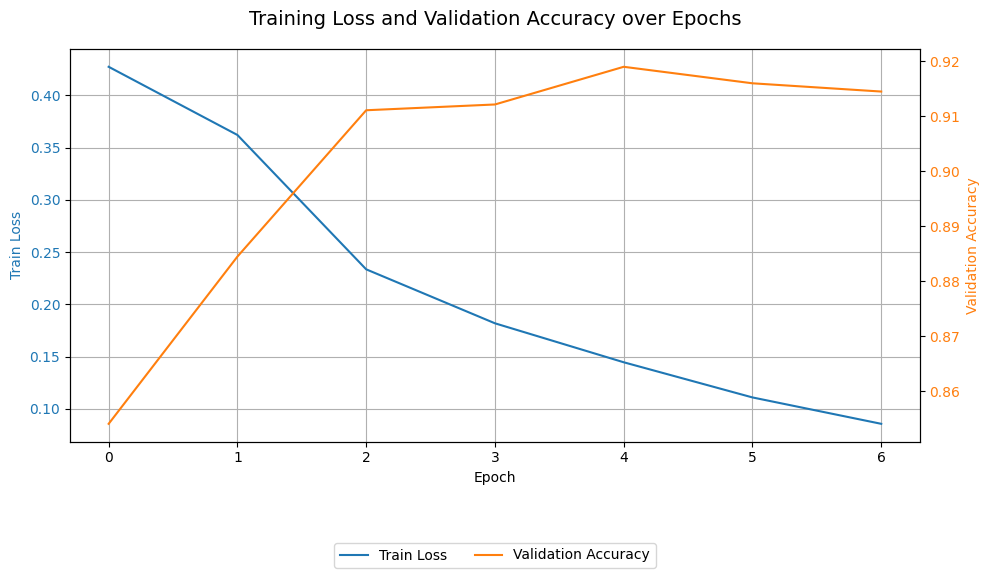

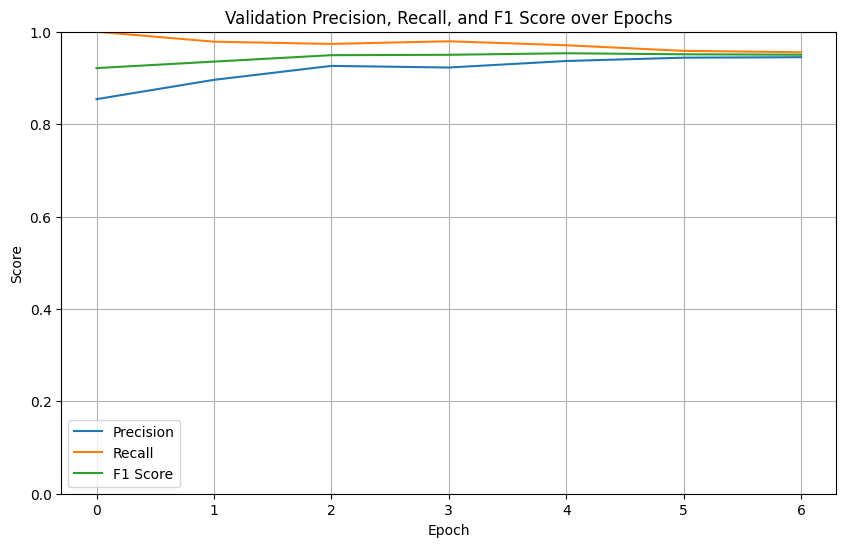

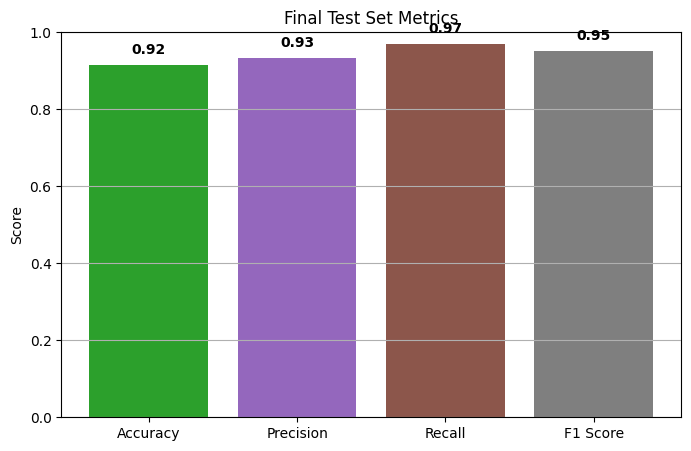

In [17]:
# Plot Training Loss and Validation Accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Training Loss
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(train_losses, label='Train Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

# Second y-axis for Validation Accuracy
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Validation Accuracy', color=color)
ax2.plot(val_accuracies, label='Validation Accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Titles
fig.suptitle('Training Loss and Validation Accuracy over Epochs', fontsize=14)
fig.tight_layout()
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()


# Plot Validation Precision, Recall, F1
plt.figure(figsize=(10, 6))

plt.plot(val_precisions, label='Precision')
plt.plot(val_recalls, label='Recall')
plt.plot(val_f1s, label='F1 Score')

plt.title('Validation Precision, Recall, and F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()


# Final Test Metrics Bar Chart
test_metrics = [test_acc, precision, recall, f1]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(8, 5))
bars = plt.bar(metric_names, test_metrics, color=['tab:green', 'tab:purple', 'tab:brown', 'tab:gray'])
plt.title('Final Test Set Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

# As we can see, the model performs very well even starting at Epoch 1. Its validation accuracy on average rises from around 0.85 to 0.90 over the course of its training, and all 3 precision, recall, and F1 scores converge at around 0.95.

# On the test set, we see an accuracy of 0.92 and very high precision, recall, and F1 scores as well.